# Weighted ECM clustering vs Traditional ECM clustering
### With Forest-Type (UCI dataset)

In [1]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from evclust.ecm import ecm
from evclust.wecm_new import wecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot, plotting, calculate_non_specificity
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from evclust.datasets import load_forest

   b1  b2  b3   b4  b5   b6   b7  b8  b9  pred_minus_obs_H_b1  ...  \
0  67  51  68  115  69  111  136  31  67                47.70  ...   
1  67  28  51   99  50   97   82  26  59                47.93  ...   
2  63  26  50   95  49   91   81  26  57                53.09  ...   
3  63  42  63   97  66  108  111  28  59                52.41  ...   
4  46  27  50   83  51   90   76  26  56                68.54  ...   

   pred_minus_obs_H_b9  pred_minus_obs_S_b1  pred_minus_obs_S_b2  \
0                -9.17               -18.27                -1.80   
1                -2.25               -20.13                -2.11   
2                -0.44               -17.64                -1.81   
3                -2.34               -20.20                -1.89   
4                 1.25               -18.62                -2.17   

   pred_minus_obs_S_b3  pred_minus_obs_S_b4  pred_minus_obs_S_b5  \
0                -6.32               -20.88                -1.63   
1                -6.35            

D:\vtdo\projects\evclust\src\evclust\utils.py:1085: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


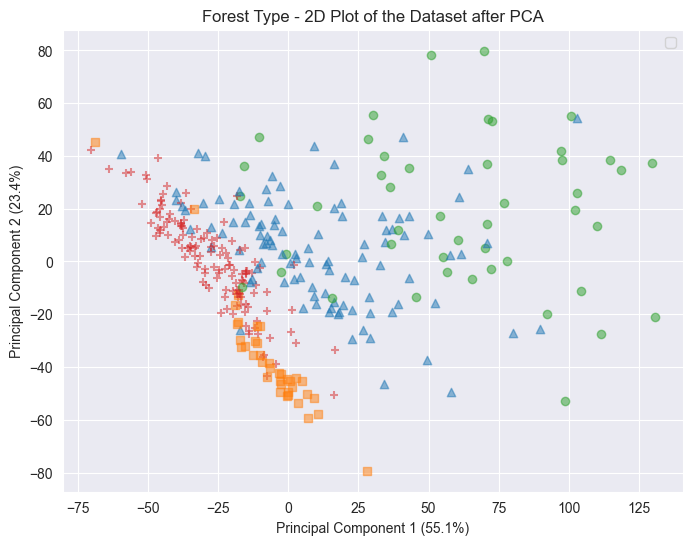

Instances: 325; Features: 27; Clusters: class    4
dtype: int64


In [11]:
### Forest Type dataset
# fetch dataset 
forest_type = load_forest()

X = forest_type.iloc[:, 1:]
y = pd.DataFrame(forest_type.iloc[:, 0])

markers = ['^', 's', 'o', '+']
plotting(X, y, "Forest Type", markers=markers)
print(f"Instances: {X.shape[0]}; Features: {X.shape[1]}; Clusters: {y.nunique()}")

scaler = MinMaxScaler((0,1))
X = pd.DataFrame(scaler.fit_transform(X))

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])


## Traditional ECM

In [14]:
%%capture
# Traditional ECM clustering
delta = np.sqrt(20)
model_list = np.array([])
for i in range(10):
    model = ecm(x=X, c=4, beta=2, alpha=1, delta=delta, ntrials=1, init="kmeans")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda x : x['crit'])
# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

J values: [25.46630296973878, 25.46650310460844, 25.466540504373622, 25.466614679663618, 25.4666230368949, 25.466634090139475, 25.46666680307702, 25.466738444990806, 25.466805827943272, 25.466846623970426]
ARI values: [0.16284584167341998, 0.17744831320589108, 0.17958613893573622, 0.17958613893573622, 0.18231717142604373, 0.18231717142604373, 0.1903529328500496, 0.18752918035180458, 0.187896171560722, 0.19559946001488687]
NS values: [1.7281874807201503, 1.719084452398202, 1.716882873169454, 1.7194394240303763, 1.7569831880460534, 1.8619040419446873, 1.8617262541058828, 1.7272329905235837, 1.861098815108466, 1.718924400963188]
NMI values: [0.26019048800452516, 0.2759373176608175, 0.2766172852161723, 0.2766172852161723, 0.27885187156383817, 0.27885187156383817, 0.2852397657382418, 0.27912926152353335, 0.27907232689531963, 0.29010591831858423]
Average ARI values: 0.18254785203803342
Average Non-specificity: 1.7671463921010044
Average Normalized mutual infor: 0.2780613391701042
Center: [[0

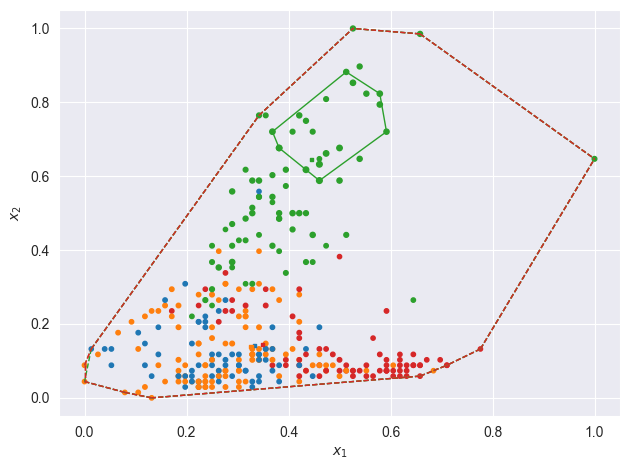

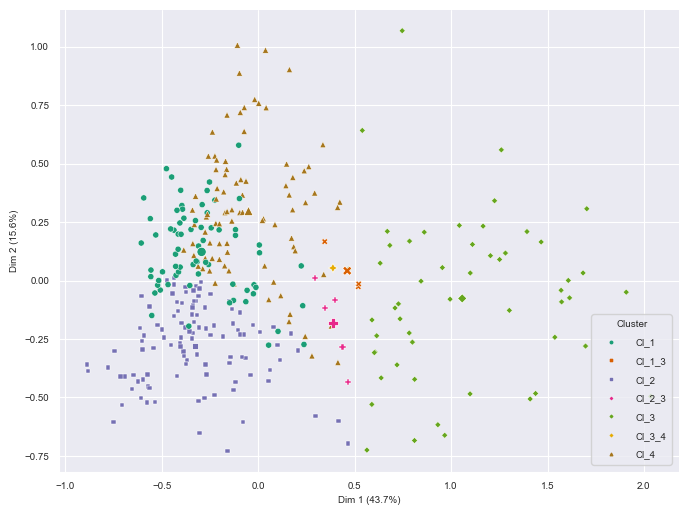

In [15]:
print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")
print(f"Center: {model_list[0]['g']}")
# Plotting the the model with the minimum J value
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

## Weighted ECM (WECM)

In [25]:
# %%capture
# Weighted ECM clustering
model_list = np.array([])
c = 4
d = X.shape[1]
for i in range(10):
    W = np.ones((c, d)) * (1/d)
    # W = None
    g0 = None
    delta = np.sqrt(20)
    model = wecm(x=X, c=c, g0=g0, W=W, beta=2, alpha=1, delta=delta, epsi=1e-3, ntrials=1, init="kmeans", stopping_factor="center")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda model: model['crit'])

# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

Initial weights: 
 [[0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704]
 [0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704]
 [0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704]
 [0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 

J values: [0.034394844195195964, 0.03439527350335207, 0.03439538697031271, 0.03439555015788822, 0.03439555015788822, 0.03439585965780616, 0.0343969100705982, 0.034398155865967395, 0.03440123754354735, 0.034402691969705836]
ARI values: [0.1817531670939388, 0.18234576883866177, 0.17678907650723075, 0.18295195320307042, 0.18295195320307042, 0.18224218789988908, 0.18224218789988908, 0.18234576883866177, 0.19007536585608745, 0.18204197464031252]
NS values: [1.7442689386493127, 1.8784222453669022, 1.8730034362976096, 1.8784706944301637, 1.8756103922914578, 1.7411754718935846, 1.8731410255814804, 1.8756929381784047, 1.7763939647145868, 1.7303638877823022]
NMI values: [0.2857319000018132, 0.28684815002893876, 0.27968717914179136, 0.2873927070064518, 0.2873927070064518, 0.28681276371393793, 0.28681276371393793, 0.28684815002893876, 0.30206355003447044, 0.28649487589512623]
Average ARI values: 0.18257394039808122
Average Non-specificity: 1.8246542995185806
Average Normalized mutual infor: 0.2876

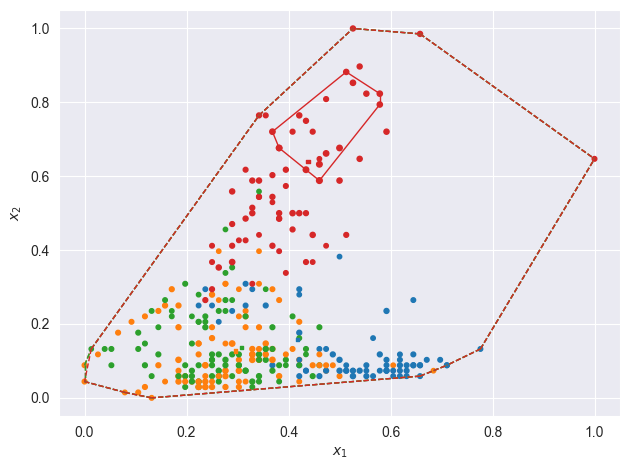

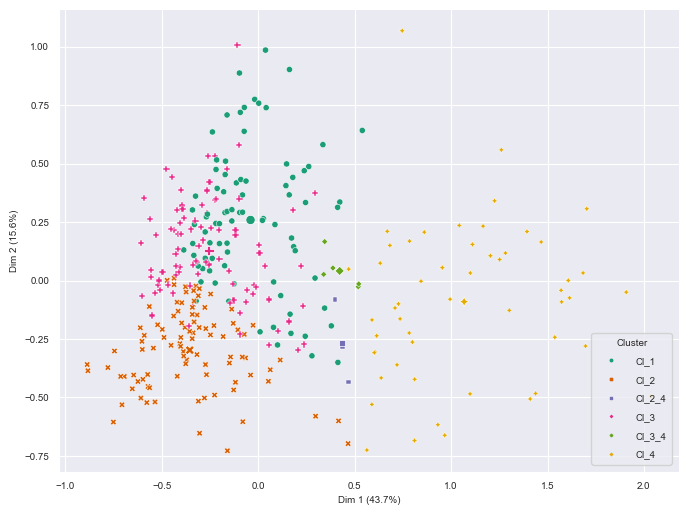

In [26]:
print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

# Plotting PCA of the best model
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

In [24]:
print(model_list[0]['W'])

[[0.01971948 0.02737741 0.03585812 0.022429   0.03485231 0.03977878
  0.02348369 0.09091794 0.07699695 0.02078381 0.02885713 0.03811551
  0.0165615  0.03417288 0.03998511 0.02210445 0.0906805  0.07550585
  0.02226004 0.03034434 0.02236159 0.02172073 0.02978028 0.02868798
  0.02207249 0.05039316 0.03419899]
 [0.06584424 0.0194538  0.01986896 0.02840554 0.02577502 0.02785636
  0.02124446 0.01649191 0.01397183 0.06784474 0.02132397 0.0229356
  0.02268751 0.02562594 0.02797076 0.02088928 0.01656378 0.01324117
  0.06391867 0.06444627 0.04556948 0.06949097 0.03938239 0.05507749
  0.0618514  0.06666857 0.05559989]
 [0.02184094 0.0320348  0.03994361 0.02609682 0.038177   0.03963117
  0.01784227 0.09692268 0.07939675 0.0224354  0.03284823 0.04073791
  0.01919759 0.03745934 0.03919065 0.0169886  0.09634148 0.07790212
  0.02432761 0.02010921 0.01789049 0.01608211 0.02656279 0.02564198
  0.02175184 0.04482566 0.02782096]
 [0.02606667 0.02906975 0.0349792  0.02880147 0.03678464 0.03753591
  0.02050